In [87]:
import pandas as pd
import numpy as np
import random

import gym
from gym.spaces import Discrete, Box, Dict

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
class LifecycleEnv(gym.Env):
    def __init__(self):
        # Here we define the choices on consumption and equity allocation
        self.action_space = Dict({"equity_allocation": Discrete(101),
                                  "consumption": Discrete(20)})
        # Set starting variables
        self.wealth = 0
        self.starting_income = 100
        self.income = self.starting_income
        self.starting_age = 20
        self.age = self.starting_age
        self.retirement_age = 70
        self.terminal_age = 115
        self.max_wealth = 100000
        self.total_consumption = 0
        # Here we create our observation space
        self.observation_space = Dict({"age": Discrete(self.terminal_age - self.starting_age + 1)})

    def step(self, action):
        # Income reduces when you retire
        if self.age > self.retirement_age:
            self.income = 0
        # define market returns
        risk_return = 0.05
        risk_free_return = 0.02
        # tranformation
        #print(action)
        action_equity_allocation = action["equity_allocation"] / 100
        action_consumption = action["consumption"] * 10
        # Apply action
        portfolio_return = risk_return * \
            action_equity_allocation + risk_free_return * \
            (1 - action_equity_allocation)
        self.wealth = (1 + portfolio_return) * (self.wealth -
                                                action_consumption) + self.income
        self.total_consumption += (action_consumption)
        # force wealth to be in grid - need to work on this
        if self.wealth > self.max_wealth:
            self.wealth = self.max_wealth
        if self.wealth < 0:
            self.wealth = 0
        self.wealth = int(self.wealth)
        # Time passes (philosophical consideration here)
        self.age += 1
        # Complete step if agent is older than terminal age
        if self.age == self.terminal_age:
            done = True
            reward = self.total_consumption
        else:
            done = False
            reward = 0
        # Placeholder for info
        info = {"age": self.age, "wealth": self.wealth, "consumption": action_consumption, "equity_allocation": action_equity_allocation}
        state = {"age": self.age, "wealth": self.wealth}
        return state, reward, done, info

    def render(self, mode='human'):
        # no urgent need for this
        pass

    def reset(self):
        # Resetting age and wealth
        self.wealth = 0
        self.age = self.starting_age
        self.income = self.starting_income
        self.total_consumption = 0
        state = {"age": self.age, "wealth": self.wealth}
        return state


env = LifecycleEnv()
# Observation and action space
print("The observation space: {}".format(env.observation_space))
print("The action space: {}".format(env.action_space))


The observation space: Dict(age:Discrete(96))
The action space: Dict(consumption:Discrete(20), equity_allocation:Discrete(101))


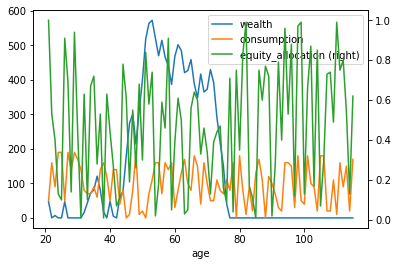

In [94]:
# Hyperparameters
minutes = 1
epochs = 400 * int(minutes * 100 / 60)
num_steps = env.terminal_age - env.starting_age
epsilon = 0.1
alpha = 0.9
gamma = 0.6

# env setup
state = env.reset()
best_action = OrderedDict()
info_df = pd.DataFrame(
    columns=("age", "wealth", "consumption", "equity_allocation"))
# my q table consist of 2 state actions and 2 observation spaces
# I need to change one of the observation space variables into a continuos one and use function approximation
q_table = np.zeros([env.observation_space["age"].n, env.action_space["equity_allocation"].n, env.action_space["consumption"].n])

for epoch in range(epochs):
    # this is a greedy implementation
    epsilon = 1 - (epoch / epochs)
    for step in range(num_steps):
        # take random action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            # here I select the best action based on my q table
            q = q_table[state["age"] - env.starting_age]
            max_q_index = np.unravel_index(np.argmax(q, axis=None), q.shape)
            best_action['consumption'] = max_q_index[1]
            best_action['equity_allocation'] = max_q_index[0]
            action = best_action  # Exploit learned values

        # apply the action
        next_state, reward, done, info = env.step(action)
        # Render the env
        info_df = info_df.append(info, ignore_index=True) 
        
        old_value = q_table[state["age"] - env.starting_age, action["equity_allocation"], action["consumption"]]
        next_max = np.max(q_table[next_state["age"] - env.starting_age])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state["age"] - env.starting_age, action["equity_allocation"], action["consumption"]] = new_value

        # If the episode is up, then start another one
        if done:
            if epoch < epochs - 1:
                info_df = pd.DataFrame(
                    columns=("age", "wealth", "consumption", "equity_allocation"))
            env.reset()

        state = next_state

# print(info_df.set_index("age"))
info_df.set_index("age").plot(secondary_y=["equity_allocation"])

# Close the env
env.close()


In [95]:
pd.DataFrame(q_table.mean(axis=1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3.177470e-19,4.877553e-19,4.035979e-19,3.403361e-20,3.058061e-19,4.915425e-20,2.790105e-19,3.158050e-19,6.102558e-19,6.555017e-19,6.296721e-19,2.693271e-19,2.123796e-19,3.448102e-19,9.138134e-20,4.537748e-19,1.201462e-18,2.493128e-19,4.044846e-19,1.192143e-19
2,1.357095e-19,6.524325e-21,3.027354e-19,6.506372e-19,7.784129e-19,2.123383e-21,5.346023e-19,4.704767e-19,8.130733e-19,1.364468e-18,4.186453e-19,7.939316e-19,5.588700e-19,9.783704e-20,1.406209e-20,6.788904e-19,3.498821e-19,2.215894e-19,1.932327e-19,3.466539e-19
3,7.770581e-19,7.361491e-19,7.214470e-19,8.560452e-19,6.843657e-19,1.968295e-18,1.278445e-18,1.452750e-18,9.724924e-19,2.652592e-19,1.151732e-18,9.855833e-21,5.502550e-19,1.523193e-18,5.541203e-19,1.205615e-18,1.177407e-18,2.852497e-19,3.260644e-19,2.161861e-18
4,1.546381e-18,1.021116e-18,4.003563e-18,1.282038e-18,1.912937e-18,1.147521e-18,1.694442e-18,8.988124e-19,1.554036e-18,1.665940e-18,5.277169e-19,8.577806e-19,3.829564e-19,1.048556e-18,2.906141e-18,2.123782e-18,3.420774e-18,9.613117e-19,7.977490e-19,1.635738e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.707173e+02,2.478187e+02,7.305144e+01,1.284829e+02,2.096550e+02,9.022642e+01,2.112651e+02,1.793973e+02,1.573425e+02,1.426242e+02,2.960970e+02,2.399240e+02,2.084732e+02,1.782560e+02,1.386330e+02,1.554667e+02,1.278715e+02,1.044270e+02,2.278175e+02,1.268194e+02
92,2.045024e+02,2.042635e+02,2.655946e+02,1.225896e+02,1.715937e+02,2.659162e+02,3.841895e+02,2.655519e+02,3.269890e+02,3.821304e+02,4.830556e+02,2.368694e+02,2.907255e+02,2.943961e+02,3.853394e+02,1.167673e+02,4.076513e+02,1.905979e+02,2.057488e+02,1.474748e+02
93,6.406631e+02,2.930990e+02,7.503584e+02,1.922936e+02,3.984372e+02,4.408983e+02,4.931278e+02,2.944698e+02,8.900804e+02,6.454433e+02,4.859229e+02,6.390358e+02,3.442726e+02,2.480117e+02,4.873073e+02,4.292729e+02,9.271143e+01,4.854951e+02,3.396128e+02,4.331626e+02
94,1.325584e+03,7.343465e+02,6.217129e+02,6.283960e+02,4.864417e+02,1.055557e+03,6.324059e+02,1.127412e+03,6.516675e+02,5.488717e+02,6.721485e+02,5.635417e+02,7.280319e+02,9.044871e+02,1.101832e+03,4.844851e+02,3.338644e+02,1.025350e+03,1.038673e+03,5.732788e+02


<AxesSubplot:>

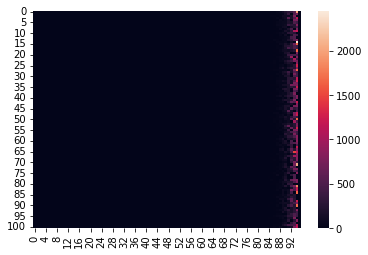

In [100]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=2)).T)